In [1]:
# Ho Chi Minh city University of Science (HCMUS)
# Author: Phan Minh Phuc
# Student ID: 20127063
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as img

In [2]:
def brightness_changing (filename, img_1d, row, column, channel):
    brightness = int(input("Enter the brightness you want to change: "))
    print(f"Brightness: {brightness}")
    new_image = np.add(img_1d, brightness)
    new_image = np.clip(new_image, 0, 255)
    new_image = new_image.reshape((row, column, channel))
    plt.clf()
    figure = plt.figure()
    figure.set_size_inches(column / 96, row / 96)
    plt.axis("off")
    plt.imshow(new_image)
    plt.savefig(filename + "_changed_brightness.png", dpi = 300)

In [3]:
def contrast_changing(filename, img_1d, row, column, channel):
    contrast = int(input("Enter the contrast you want to change: "))
    print(f"Contrast: {contrast}")
    new_image = np.multiply(img_1d, contrast)
    new_image = np.clip(new_image, 0, 255)
    new_image = new_image.reshape((row, column, channel))
    plt.clf()
    figure = plt.figure()
    figure.set_size_inches(column / 96, row / 96)
    plt.axis("off")
    plt.imshow(new_image)
    plt.savefig(filename + "_changed_contrast.png", dpi = 300)

In [4]:
def flip_image(filename, img_1d, row, column, channel):
    flip = input("Enter the way you want to flip the image" 
                 + " ('V' - vertically (up-down) or 'H' - horizontally (left-right)): ")
    flip = (flip == "H" and "horizontally") or (flip == "V" and "vertically") or "Error: Invalid input!"
    print("Flip: " + flip)
    while flip == "Error: Invalid input!":
        flip = input("Enter the way you want to flip the image" 
                     + " ('V' - vertically (up-down) or 'H' - horizontally (left-right)): ")
        flip = (flip == "H" and "horizontally") or (flip == "V" and "vertically") or "Error: Invalid input!"
        print("Flip: " + flip)
        
    # Flip ndarray vertically: np.flipud()    
    # numpy.flipud() is equivalent to slice [::-1]
    if flip == "vertically":
        new_image = np.flipud(img_1d.reshape(row, column, channel)) 
    # Flip ndarray horizontally: np.fliplr()
    # numpy.fliplr() is equivalent to slice [:, ::-1]
    else:
        new_image = np.fliplr(img_1d.reshape(row, column, channel))    

    plt.clf()
    figure = plt.figure()
    figure.set_size_inches(column / 96, row / 96)
    plt.axis("off")
    plt.imshow(new_image)
    plt.savefig(filename + "_flip_image_" + flip + ".png", dpi = 300)

In [5]:
def grayscale(filename, img_1d, row, column, channel):
    method = input("Enter the method you want to grayscale the image" 
                   + " ('A' - average method or 'W' - weighted method): ")
    method = (method == "A" and "average") or (method == "W" and "weighted") or "Error: Invalid input!"
    print("Method: " + method)
    while method == "Error: Invalid input!":
        method = input("Enter the method you want to grayscale the image" 
                       + " ('A' - average method or 'W' - weighted method): ")
        method = (method == "A" and "average") or (method == "W" and "weighted") or "Error: Invalid input!"
        print("Method: " + method)
        
    if method == "average":
        R, G, B = img_1d[:, 0], img_1d[:, 1], img_1d[:, 2] 
        new_image = R / 3 + G / 3 + B / 3
    else:
        new_image = np.dot(img_1d[...,:3], [0.2989, 0.5870, 0.1140]) 

    new_image = new_image.reshape(row, column, 1)    

    plt.clf()
    figure = plt.figure()
    figure.set_size_inches(column / 96, row / 96)
    plt.axis("off")
    plt.imshow(new_image, cmap="gray")
    plt.savefig(filename + "_" + method + "_grayscale.png", dpi = 300)
    return new_image

In [6]:
def combine_grayscale(filename, img_1d, row, column, channel):
    second_filename = input("Enter the second image's name: ")
    print("Second image's name: " + second_filename)
    
    second_img_1d = np.asarray(img.open(second_filename))
    second_img_1d = second_img_1d.reshape(-1, 3)
    second_img_1d =  second_img_1d.astype(np.uint16)
    
    gray_img1 = grayscale(filename, img_1d, row, column, channel)
    gray_img2 = grayscale(second_filename, second_img_1d, row, column, channel)
    
    ratio = float(input("Enter the ratio of the 1st image to the merged image (from 0 to 1): "))
    print(f"The ratio of the 1st image to the merged image: {ratio}")
    print(f"The ratio of the 2nd image to the merged image: {1 - ratio}")
    while ratio > 1 or ratio < 0:
        print("Error: Invalid ratio!")
        ratio = float(input("Enter the ratio of the 1st image to the merged image (from 0 to 1): "))
        print(f"The ratio of the 1st image to the merged image: {ratio}")
        print(f"The ratio of the 2nd image to the merged image: {1 - ratio}")
    
    new_image = gray_img1 * ratio + gray_img2 * (1 - ratio)
    
    plt.clf()
    figure = plt.figure()
    figure.set_size_inches(column / 96, row / 96)
    plt.axis("off")
    plt.imshow(new_image, cmap="gray")
    plt.savefig(filename + "_combine_" + second_filename + f"_{ratio}_{1-ratio}" + ".png", dpi = 300)

In [7]:
def gaussian_filter(img_1d, row, column, channel, kernel_size = 3, sigma = 1):
    kernel_size = int((kernel_size - 1) / 2)
    # print(kernel_size)
    # Gaussian blur kernel_size × kernel_size 
    # default: kernel_size = 3, sigma = 1, mu = 0
    gauss = [np.exp(-z*z / (2 * sigma*sigma)) / np.sqrt(2 * np.pi * sigma*sigma) for z in range(-kernel_size * sigma, kernel_size * sigma + 1)] 
    kernel = np.outer(gauss, gauss) 
    # print(kernel.shape)
    result = np.ndarray(img_1d.shape)
    strides = 1
    padding = kernel_size
    
    for i in range(channel):  
        im = img_1d[:,:,i]
        
        # Cross Correlation
        # Gather Shapes of Kernel + Image + Padding
        xKernShape = kernel.shape[0]
        yKernShape = kernel.shape[1]
        xImgShape = im.shape[0]
        yImgShape = im.shape[1]
        # print(xKernShape)
        # print(yKernShape)
        # print(xImgShape)
        # print(yImgShape)

        # Shape of Output Convolution
        xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
        yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
        output = np.zeros((xOutput, yOutput))
        # print(output.shape)
        
        # Apply Equal Padding to All Sides
        if padding != 0:
            imagePadded = np.zeros((row + padding * 2, column + padding * 2))
            imagePadded[padding:imagePadded.shape[0] - padding, padding:imagePadded.shape[1] - padding] = im
        else:
            imagePadded = img_1d
        # print(imagePadded.shape)
            
        # Iterate through image
        for y in range(padding, imagePadded.shape[1] - padding):
            # Exit Convolution
            if y > imagePadded.shape[1] - yKernShape:
                break
            # Only Convolve if y has gone down by the specified Strides
            if y % strides == 0:
                for x in range(padding, imagePadded.shape[0] - padding):
                    # Go to next row once kernel is out of bounds
                    if x > imagePadded.shape[0] - xKernShape:
                        break
                    try:
                        # Only Convolve if x has moved by the specified Strides
                        if x % strides == 0:
                            output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                    except:
                        break
                    
        size = output.shape[:2]     
        result[:size[0],:size[1],i] = output[:,:]
    
    # print(result.shape)
    return result.astype(np.uint16)

In [8]:
def blur(filename, img_1d, row, column, channel):
    new_image = img_1d.reshape(row, column, channel)
    new_image = gaussian_filter(new_image, row, column, channel, 3, 1)
    plt.clf()
    figure = plt.figure()
    figure.set_size_inches(column / 96, row / 96)
    plt.axis("off")
    plt.imshow(new_image)
    plt.savefig(filename + "_blur.png", dpi = 300)

In [9]:
def create_circular_mask(row, column, center = None, radius = None):
    if center is None: # use the middle of the image
        center = (int(column / 2), int(row / 2))
    if radius is None: # use the smallest distance between the center and image's edges
        radius = min(center[0], center[1], column - center[0], row - center[1])
    print(f"Center: {center}.\nRadius: {radius}.\n")
    
    Y, X = np.ogrid[:row, :column]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    circle_mask = dist_from_center <= radius
    return circle_mask

In [10]:
def create_elliptical_mask(row, column, center = None):
    # Create an ellipse shaped mask
    if center is None: # use the middle of the image
        center = (int(column / 2), int(row / 2))
    print(f"Center: {center}.\n")
    
    Y, X = np.ogrid[:row, :column]
    # Distance to ellipse's semi-axis
    a = (max(row, column) / 2 * 125 / 100)** 2
    # print(a)
    b = (max(row, column) / 4 * 125 / 100)** 2 

    rotate1 = np.pi / 4
    dist_from_F1 = ((X - center[0]) * np.cos(rotate1) + (Y - center[1]) * np.sin(rotate1))**2 / a
    dist_from_F2 = ((X - center[0]) * np.sin(rotate1) - (Y - center[1]) * np.cos(rotate1))**2 / b
    ellipse_mask1 = dist_from_F1 + dist_from_F2 <= 1

    rotate2 = -np.pi / 4
    dist_from_F3 = ((X - center[0]) * np.cos(rotate2) + (Y - center[1]) * np.sin(rotate2))**2 / a
    dist_from_F4 = ((X - center[0]) * np.sin(rotate2) - (Y - center[1]) * np.cos(rotate2))**2 / b
    ellipse_mask2 = dist_from_F3 + dist_from_F4 <= 1

    # ellipse_mask = ellipse_mask1 + ellipse_mask2
    ellipse_mask = ellipse_mask1 + ellipse_mask2
    return ellipse_mask

In [11]:
def circular_cropping(filename, img_1d, row, column):
    circle_mask = create_circular_mask(row, column)
    masked_img = img_1d.copy()
    masked_img[~circle_mask] = np.zeros((1, 1, 3))
    
    plt.clf()
    figure = plt.figure()
    figure.set_size_inches(column / 96, row / 96)
    plt.axis("off")
    plt.imshow(masked_img)
    plt.savefig(filename + "_circular_cropping.png", dpi = 300)

In [12]:
def elliptical_cropping(filename, img_1d, row, column):
    ellipse_mask = create_elliptical_mask(row, column)
    masked_img = img_1d.copy()
    masked_img[~ellipse_mask] = np.zeros((1, 1, 3))
    
    plt.clf()
    figure = plt.figure()
    figure.set_size_inches(column / 96, row / 96)
    plt.axis("off")
    plt.imshow(masked_img)
    plt.savefig(filename + "_elliptical_cropping.png", dpi = 300)

In [13]:
def cropping(filename, img_1d, row, column, channel):
    new_image = img_1d.reshape(row, column, channel)
    method = input("Enter the method you want to crop the image" 
                   + " ('C' - circular method or 'E' - elliptical method): ")
    method = (method == "C" and "circular") or (method == "E" and "elliptical") or "Error: Invalid input!"
    print("Method: " + method)
    while method == "Error: Invalid input!":
        method = input("Enter the method you want to crop the image" 
                       + " ('C' - circular method or 'E' - elliptical method): ")
        method = (method == "C" and "circular") or (method == "E" and "elliptical") or "Error: Invalid input!"
        print("Method: " + method) 
    if method == "circular":
        circular_cropping(filename, new_image, row, column)
    else:
        elliptical_cropping(filename, new_image, row, column)

In [14]:
def main():
    filename = input("Enter image's name: ")
    print("Image's name: " + filename)   
    img_1d = np.asarray(img.open(filename))
    row, column, channel = img_1d.shape
    img_1d = img_1d.reshape(-1, 3)
    img_1d =  img_1d.astype(np.uint16)
    print("\nUser manual\n" 
          + "1. Change image's brightness.\n" 
          + "2. Change image's contrast.\n"
          + "3. Flip image.\n"
          + "4. Grayscale.\n"
          + "5. Combine 2 images (gray images only).\n"
          + "6. Bluring (Gaussian filter).\n"
          + "7. Crop image.\n" 
          + "0. All above functions.\n")
    user_choice = int(input("Enter the function you need: "))
    
    if user_choice == 1:
        print("1. Change image's brightness.\n")
        brightness_changing (filename, img_1d, row, column, channel)
    elif user_choice == 2:
        print("2. Change image's contrast.\n")
        contrast_changing(filename, img_1d, row, column, channel)
    elif user_choice == 3:
        print("3. Flip image.\n")
        flip_image(filename, img_1d, row, column, channel)
    elif user_choice == 4:
        print("4. Grayscale.\n")
        grayscale(filename, img_1d, row, column, channel)
    elif user_choice == 5:
        print("5. Combine 2 images (gray images only).\n")
        combine_grayscale(filename, img_1d, row, column, channel)
    elif user_choice == 6:
        print("6. Bluring (Gaussian filter).\n")
        blur(filename, img_1d, row, column, channel)
    elif user_choice == 7:
        print("7. Crop image.\n")
        cropping(filename, img_1d, row, column, channel)
    elif user_choice == 0:
        print("0. All above functions.\n")
        
        print("1. Change image's brightness.\n")
        brightness_changing (filename, img_1d, row, column, channel)
        
        print("2. Change image's contrast.\n")
        contrast_changing(filename, img_1d, row, column, channel)
        
        print("3. Flip image.\n")
        flip_image(filename, img_1d, row, column, channel)
        
        print("4. Grayscale.\n")
        grayscale(filename, img_1d, row, column, channel)
        
        print("5. Combine 2 images (gray images only).\n")
        combine_grayscale(filename, img_1d, row, column, channel)
        
        print("6. Bluring (Gaussian filter).\n")
        blur(filename, img_1d, row, column, channel)
        
        print("7. Crop image.\n")
        cropping(filename, img_1d, row, column, channel)     
    else:
            print("Error: Invalid input!\n")

Enter image's name: 6.jpg
Image's name: 6.jpg

User manual
1. Change image's brightness.
2. Change image's contrast.
3. Flip image.
4. Grayscale.
5. Combine 2 images (gray images only).
6. Bluring (Gaussian filter).
7. Crop image.
0. All above functions.

Enter the function you need: 0
0. All above functions.

1. Change image's brightness.

Enter the brightness you want to change: 30
Brightness: 30
2. Change image's contrast.

Enter the contrast you want to change: 2
Contrast: 2
3. Flip image.

Enter the way you want to flip the image ('V' - vertically (up-down) or 'H' - horizontally (left-right)): H
Flip: horizontally
4. Grayscale.

Enter the method you want to grayscale the image ('A' - average method or 'W' - weighted method): A
Method: average
5. Combine 2 images (gray images only).

Enter the second image's name: 4.jpg
Second image's name: 4.jpg
Enter the method you want to grayscale the image ('A' - average method or 'W' - weighted method): W
Method: weighted
Enter the method you

<Figure size 432x288 with 0 Axes>

<Figure size 384x384 with 0 Axes>

<Figure size 384x384 with 0 Axes>

<Figure size 384x384 with 0 Axes>

<Figure size 384x384 with 0 Axes>

<Figure size 384x384 with 0 Axes>

<Figure size 384x384 with 0 Axes>

<Figure size 384x384 with 0 Axes>

<Figure size 384x384 with 0 Axes>

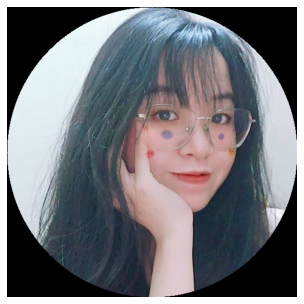

In [15]:
main()